# VencoPy Tutorial 1

This tutorial showcases the general structure and workflow of VencoPy, as well as some basic features of its 4 main classes:
- DataParser
- TripDiaryBuilder
- GridModeler
- FlexEstimator

All tutorials run on a very small subset of data from the 2017 German national travel survey (Mobilität in Deutschland (MiD17)), which might result in profiles having uncommon shapes. As such, the calculations and the examples proposed throughout all tutorials have the mere goal to exemplify the modelling steps and guide the use throughout the structure of VencoPy and do not aim at providing an accurate quantification of demand-side flexibility from EVs.

For a more detailed description of the VencoPy, you can refer to https://www.mdpi.com/1996-1073/14/14/4349/htm

## Setting up the working space

This section allows you to import all required Python packages for data input and manipulation. The function os.chdir(path) allows us to point Python towards the top most directory which contains all useful VencoPy funtions that are going to be used in the tutorials.
Additionally we set and read in the input dataframe (here the MiD17) and load the necessary yaml file, which contains some configuration settings.

In [43]:
import sys
import os
from os import path
import pandas as pd
from pathlib import Path

sys.path.append(path.dirname(path.dirname(path.dirname(Path.cwd()))))


In [44]:
from vencopy.classes.dataParsers import DataParser
from vencopy.classes.tripDiaryBuilders import TripDiaryBuilder
from vencopy.classes.gridModelers import GridModeler
from vencopy.classes.flexEstimators import FlexEstimator
from vencopy.classes.evaluators import Evaluator
from vencopy.scripts.globalFunctions import loadConfigDict, createOutputFolders

print("Current working directory: {0}".format(os.getcwd()))

Current working directory: C:\8_Work\VencoPy\vencopy_internal\vencopy\vencopy\tutorials\tutorial_01


We will have a look more in detail at each config file and what you can specify within it for each class throughtout the tutorials. For the time being, it is enough to know that the config files specify configurations, variable namings and settings for the different classes. There is one config file for each class, a global config and a local configuration config to specify eventual file paths on your machine.


In [45]:
configNames = ('globalConfig', 'localPathConfig', 'parseConfig', 'tripConfig', 'gridConfig', 'flexConfig', 'evaluatorConfig')
configDict = loadConfigDict(configNames)

## _DataParser_ class

To be able to estimate EV electric consumption and flexibililty, the first step in the VencoPy framework implies accessing a travel survey data set, such as the MiD. This is carried out through a parsing interface to the original database. In the parsing interface to the data set, three main operations are carried out: the read-in of the travel survey trip data, stored in .dta or .csv files, filtering and cleaning of the original raw data set and a set of variable replacement operations to allow the composition of travel diaries in a second step (in the tripDiaryBuilder class).


In order to have consistent entry data for all variables and for different data sets, all database entries are harmonised, which includes generating unified data types and consistent variable naming. The naming convention for the variables and their respective input type can be specified in the VencoPy-config files that have been loaded previously.

First off, we modify the localConfig and globalConfig files so that it point to the current working directory and to the database subset we will use to explain the different classes.


In [46]:
# Set reference dataset 
datasetID = 'MiD17'

# Modify the localPathConfig file to point to the .csv file in the sampling folder in the tutorials directory where the dataset for the tutorials lies.
configDict['localPathConfig']['pathAbsolute'][datasetID] = Path.cwd().parent / 'data_sampling'

# Assign to vencoPyRoot the folder in which you cloned your repository
#localPathConfig['pathAbsolute']['vencoPyRoot'] = Path.cwd().parent.parent

# Similarly we modify the datasetID in the global config file
configDict['globalConfig']['files'][datasetID]['tripsDataRaw'] = datasetID + '.csv'

# Adapt relative paths in config for tutorials
configDict['globalConfig']['pathRelative']['plots'] = Path.cwd().parent.parent / configDict['globalConfig']['pathRelative']['plots']
configDict['globalConfig']['pathRelative']['parseOutput'] = Path.cwd().parent.parent / configDict['globalConfig']['pathRelative']['parseOutput']
configDict['globalConfig']['pathRelative']['diaryOutput'] = Path.cwd().parent.parent / configDict['globalConfig']['pathRelative']['diaryOutput']
configDict['globalConfig']['pathRelative']['gridOutput'] = Path.cwd().parent.parent / configDict['globalConfig']['pathRelative']['gridOutput']
configDict['globalConfig']['pathRelative']['flexOutput'] = Path.cwd().parent.parent / configDict['globalConfig']['pathRelative']['flexOutput']
configDict['globalConfig']['pathRelative']['evalOutput'] = Path.cwd().parent.parent / configDict['globalConfig']['pathRelative']['evalOutput']

# We also modify the parseConfig by removing some of the columns that are normally parsed from the MiD, which are not available in our semplified test dataframe
del configDict['parseConfig']['dataVariables']['hhID']
del configDict['parseConfig']['dataVariables']['personID']


We can now run the first class and parse the dataset with the collection of mobility patterns into a more useful form for our scope.

In [47]:
vpData = DataParser(datasetID=datasetID, configDict=configDict, loadEncrypted=False)
vpData.process()
vpData.data.head()

Parsing properties set up
Starting to retrieve local data file from C:\8_Work\VencoPy\vencopy_internal\vencopy\vencopy\tutorials\data_sampling\MiD17.csv
Finished loading 2124 rows of raw data of type .csv
Finished harmonization of variables
Starting filtering, applying 8 filters.
The following values were taken into account after filtering:
{'isMIVDriver': 1287,
 'tripDistance': 1948,
 'tripEndClock': 2124,
 'tripEndHour': 2124,
 'tripIsIntermodal': 1682,
 'tripPurpose': 2115,
 'tripStartClock': 2124,
 'tripStartHour': 2124}
All filters combined yielded a total of 950 was taken into account
This corresponds to 44.72693032015066 percent of the original data
Finished harmonization of ID variables
Parsing completed


,isMIVDriver,hhPersonID,tripID,tripWeight,tripScaleFactor,tripStartClock,tripEndClock,tripPurpose,tripDistance,travelTime,...,tripStartMinute,tripEndHour,tripEndMinute,tripEndNextDay,tripIsIntermodal,weekdayStr,purposeStr,timestampStart,timestampEnd,genericID
3,True,1410,4,0.146627,39.299224,50400.0,53400.0,2,9.50,50.0,...,0,14,50,False,0,MON,WORK,2017-03-13 14:00:00,2017-03-13 14:50:00,1410
19,True,636,1,0.190006,50.925648,22200.0,23400.0,1,13.30,20.0,...,10,6,30,False,0,TUE,WORK,2016-07-24 06:10:00,2016-07-24 06:30:00,636
20,True,636,2,0.190006,50.925648,64800.0,66000.0,8,13.30,20.0,...,0,18,20,False,0,TUE,HOME,2016-07-24 18:00:00,2016-07-24 18:20:00,636
32,True,87,2,0.359856,96.449272,39900.0,40500.0,5,2.38,10.0,...,5,11,15,False,0,WED,SHOPPING,2017-05-17 11:05:00,2017-05-17 11:15:00,87
33,True,87,3,0.359856,96.449272,40500.0,41100.0,8,2.38,10.0,...,15,11,25,False,0,WED,HOME,2017-05-17 11:15:00,2017-05-17 11:25:00,87


We can see from the print statements in the class that after reading in the initial dataset, which contained 2124 rows, and applying 8 filters, we end up with a database containing 950 suitable entries, which corresponds to about 45% of the initial sample.


## _TripDiaryBuilder_ class

In the second VencoPy component, the travelDiaryBuilder, individual trips at the survey day are consolidated into person-specific travel diaries comprising multiple trips.


The daily travel diary composition consists of three main steps: reformatting the database, allocating trip purposes and merging the obtained dataframe with other relevant variables from the original database.


In the first step, reformatting, the time dimension is transferred from the raw data (usually in minutes) to the necessary output format (e.g., hours). Each trip is split into shares, which are then assigned to the respective hour in which they took place, generating an hourly dataframe with a timestamp instead of a dataframe containing single trip entries.


Similarly, miles driven and the trip purpose are allocated to their respective hour and merged into daily travel diaries. Trips are assumed to determine the respective person’s stay in the consecutive hours up to the next trip and therefore are related to the charging availability between two trips. Trip purposes included in surveys may comprise trips carried out for work or education reasons, trips returning to home, trips to shopping facilities and other leisure activities. Currently, trips whose purpose is not specified are allocated to trips returning to their own household.

At the end of the second VencoPy component TripDiaryBuilder, two intermediary data sets are available either directly from the class within Python or from the hard-drive as .csv files.

In [48]:
# Trip distance and purpose diary compositions
vpTripDiary = TripDiaryBuilder(datasetID=datasetID, configDict=configDict, ParseData=vpData, debug=False)


Calculating hourly shares
Trip distance diary setup starting
Finished trip distance diary setup
Starting trip purpose diary setup
Finished purpose replacements
There are 281 daily trip diaries.
Drive data and trip purposes written to files inputProfiles_Drive_beta__MiD17.csv and inputProfiles_Purpose_beta__MiD17.csv


After the calculation of the hourly shares and the composition of the 950 database rows from the DataParser class, our dataset now contains 267 trip diaries.

You can also see that the two available datasets, the drive data and the trip purposes are written to inputProfiles_Drive_masterBranch_MiD17.csv and inputProfiles_Purpose_masterBranch_MiD17.csv respectively.

## _GridModeler_ class

The charging infrastructure allocation makes use of a basic charging infrastructure model, which assumes the availability of charging stations when vehicles are parked. Since the analytical focus of the framework lies on a regional level (NUTS1-NUTS0), the infrastructure model is kept simple in the current version.


Charging availability is allocated based on a binary True–False mapping to a respective trip purpose in the VencoPy-config. Thus, different scenarios describing different charging availability scenarios, e.g., at home or at home and at work etc. can be distinguished, but neither a regional differentiation nor a charging availability probability or distribution are assumed.

At the end of the execution of the GridModeler class, a given parking purpose diary parkingType(v,t) is transferred into a binary grid connection diary connectgrid(v,t) with the same format but consisting only of True–False values.

In [49]:
vpGrid = GridModeler(datasetID=datasetID, configDict=configDict)
vpGrid.assignSimpleGridViaPurposes()
vpGrid.writeOutGridAvailability()

Starting with charge connection replacement of location purposes
Grid connection assignment complete


## _Evaluator_ class

The Evaluator class contains a collection of function to analyse and visualise the results. With the 'hourlyAggregates' and 'plotAggregates' functions we can see the average hourly trips in km in our dataset as well as the sum of total km per week day.

Evaluator initialization complete


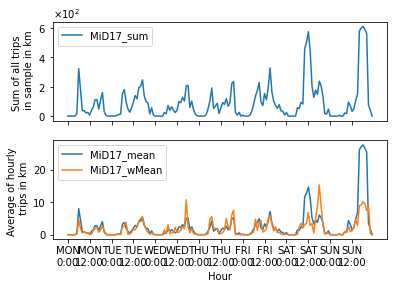

In [50]:
vpEval = Evaluator(configDict=configDict, parseData=pd.Series(data=vpData, index=[datasetID]))
vpEval.hourlyAggregates = vpEval.calcVariableSpecAggregates(by=['tripStartWeekday'])
vpEval.plotAggregates()

## _FlexEstimator_ class

The flexEstimator class is the final class that is used to estimate the charging flexibility based on driving profiles and charge connection shares.
There are three integral inputs to the flexibililty estimation:
- A profile describing hourly distances for each vehicle d(v,t)
- A boolean set of profiles describing if a vehicle is connected to the grid at a given hour connectgrid(v,t)
- Techno–economic input assumptions

After reading in the input scalars the drive profiles and the boolean plug profiles, the flexEstimator class outputs 6 profiles.


The first four profiles can be used as constraints for other models to determine optimal charging strategies; the fifth profile simulates a case where charging is not controlled an EVs charge as soon as a charging possibility becomes available. Lastly, the sixth profile quantifies the demand for additional fuel for trips that cannot be fully carried out with an EV.


In [51]:
# Estimate charging flexibility based on driving profiles and charge connection
vpFlex = FlexEstimator(datasetID=datasetID, configDict=configDict, ParseData=vpData)
vpFlex.baseProfileCalculation()
vpFlex.filter()
vpFlex.aggregate()
vpFlex.correct()
vpFlex.normalize()
vpFlex.writeOut()

Reading Venco input scalars, drive profiles and boolean plug profiles
There are 281 drive profiles and 281 plug profiles.
Flex Estimator initialization complete
Starting with iteration 0
10501.124148541114
Starting with iteration 1
0.0
Starting with iteration 2
0.0
0.0
0.0
0.0
Base profile calculation complete for dataset MiD17
There are 276 considered profiles and 273 DSM eligible profiles.


As we can see, there are 262 considered profiles and 259 DSM eligible profiles.

## _Evaluator_ class

Again using the Evaluator class, we can have a look more in detail at the grid connection share of the fleet, at the average power flow in kW in the uncontrolled charging situation anf at the power used for driving. Similarly, we can see a view of the averae minimum and maximum state of charge of the battery.

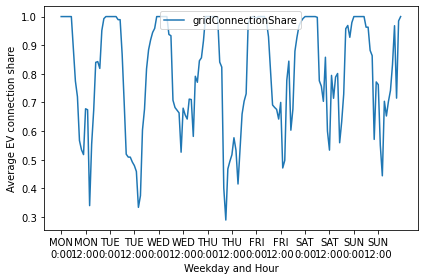

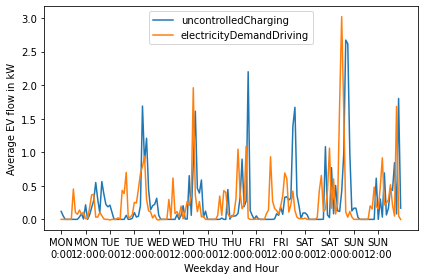

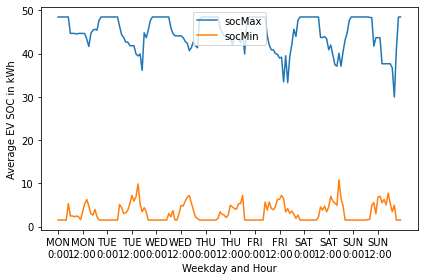

In [52]:
vpEval.plotProfiles(flexEstimator=vpFlex)

## Next Steps

In the next tutorials, you will learn more in detail the internal workings of each class and how to customise some settings.